#### What is Customer Churn?
Customer churn refers to the phenomenon where customers discontinue their relationship or subscription with a company or service provider. It represents the rate at which customers stop using a company's products or services within a specific period. Churn is an important metric for businesses as it directly impacts revenue, growth, and customer retention.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import missingno as msno
import datetime
import os

# for Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
train_df = pd.read_csv('../datasets/customer_churn_dataset-training-master.csv')
test_df = pd.read_csv('../datasets/customer_churn_dataset-testing-master.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [4]:
train_df.head()

CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0             Basic         Monthly        617.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0    1.0  
3              29.0    1.0  
4              20.0    1.0

<Axes: >

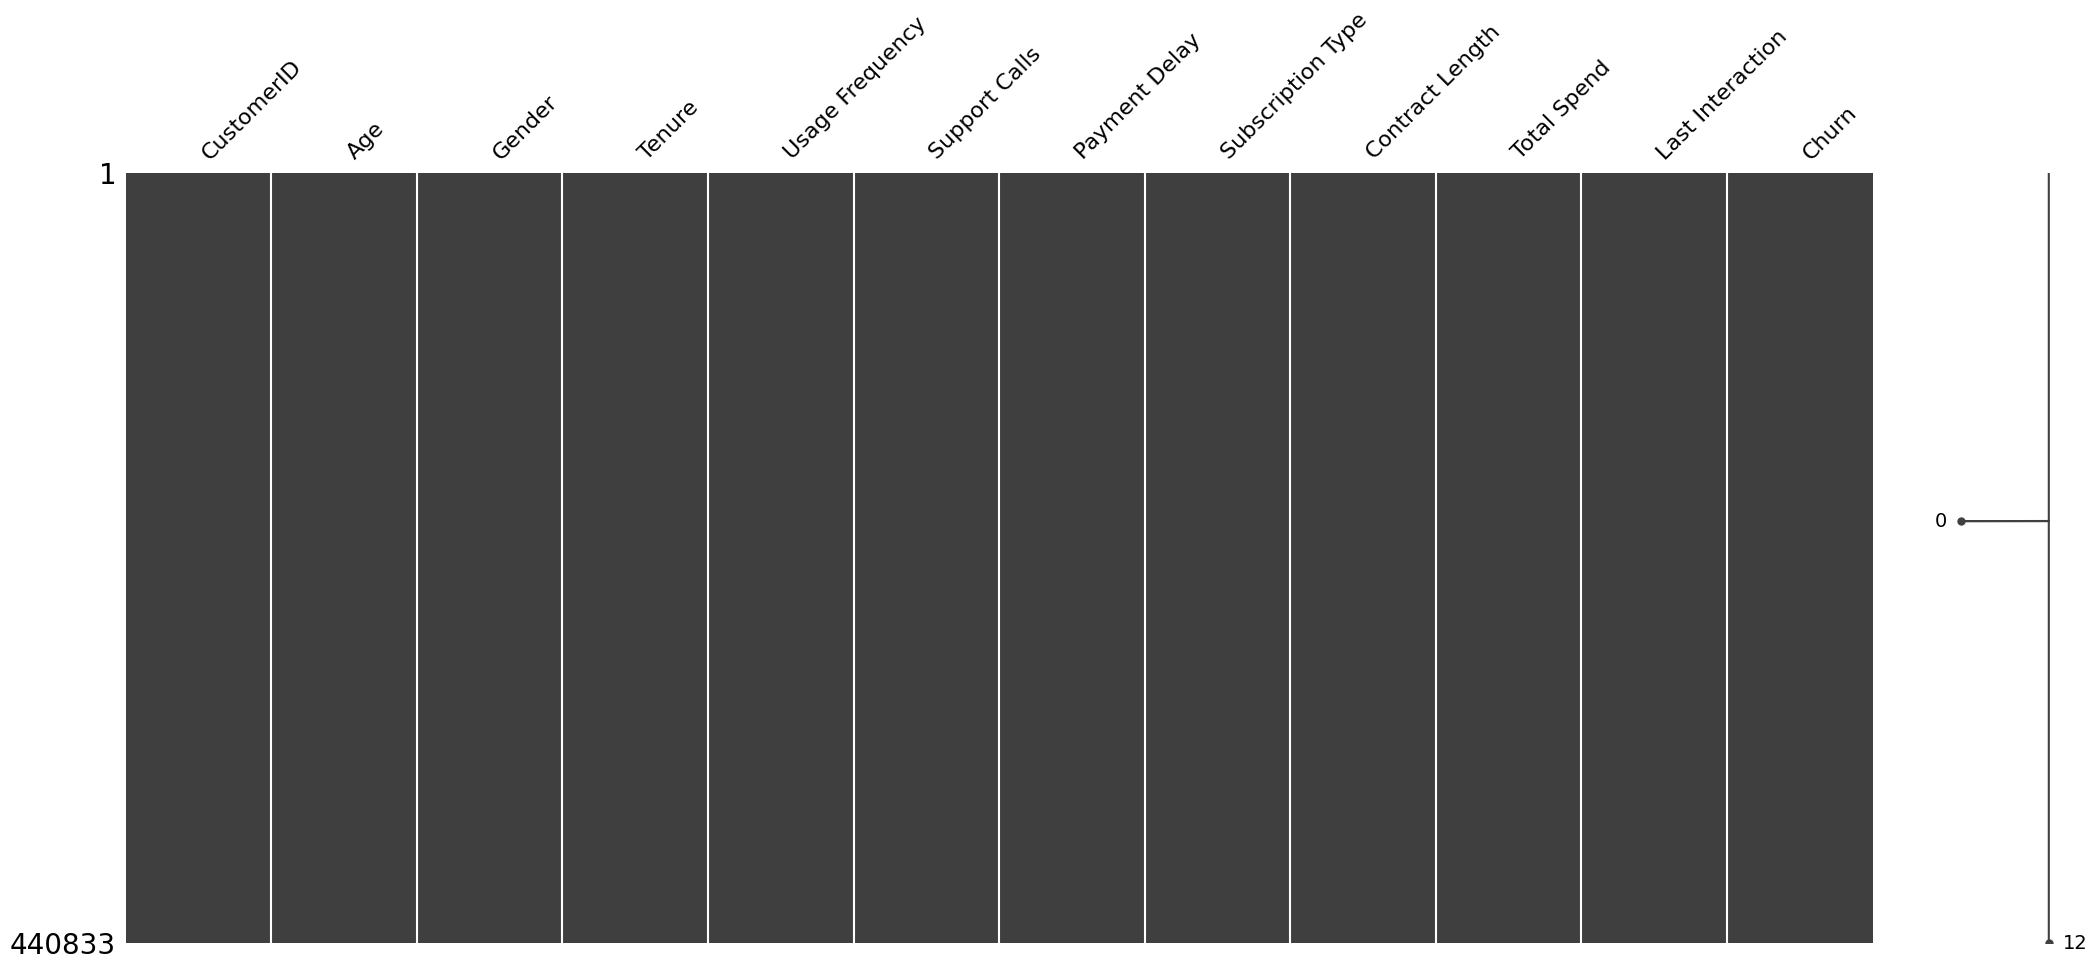

In [5]:
msno.matrix(train_df)

In [6]:
df = train_df.drop(columns = 'CustomerID') # Dropped customer ID as it's not a predictive feature
test_df = test_df.drop(columns = 'CustomerID')

In [7]:
list(df.columns)

['Age',
 'Gender',
 'Tenure',
 'Usage Frequency',
 'Support Calls',
 'Payment Delay',
 'Subscription Type',
 'Contract Length',
 'Total Spend',
 'Last Interaction',
 'Churn']

In [8]:
new_column_names = {col : col.replace(' ','_') for col in df.columns}
df = df.rename(columns = new_column_names)

In [9]:
list(df.columns)

['Age',
 'Gender',
 'Tenure',
 'Usage_Frequency',
 'Support_Calls',
 'Payment_Delay',
 'Subscription_Type',
 'Contract_Length',
 'Total_Spend',
 'Last_Interaction',
 'Churn']

In [10]:
df.isna().sum()

Age                  1
Gender               1
Tenure               1
Usage_Frequency      1
Support_Calls        1
Payment_Delay        1
Subscription_Type    1
Contract_Length      1
Total_Spend          1
Last_Interaction     1
Churn                1
dtype: int64

In [11]:
df[df['Age'].isna()]

Age Gender  Tenure  Usage_Frequency  Support_Calls  Payment_Delay  \
199295  NaN    NaN     NaN              NaN            NaN            NaN   

       Subscription_Type Contract_Length  Total_Spend  Last_Interaction  Churn  
199295               NaN             NaN          NaN               NaN    NaN

In [12]:
df = df.drop(199295)
df = df.reset_index(drop = True)
df

Age  Gender  Tenure  Usage_Frequency  Support_Calls  Payment_Delay  \
0       30.0  Female    39.0             14.0            5.0           18.0   
1       65.0  Female    49.0              1.0           10.0            8.0   
2       55.0  Female    14.0              4.0            6.0           18.0   
3       58.0    Male    38.0             21.0            7.0            7.0   
4       23.0    Male    32.0             20.0            5.0            8.0   
...      ...     ...     ...              ...            ...            ...   
440827  42.0    Male    54.0             15.0            1.0            3.0   
440828  25.0  Female     8.0             13.0            1.0           20.0   
440829  26.0    Male    35.0             27.0            1.0            5.0   
440830  28.0    Male    55.0             14.0            2.0            0.0   
440831  31.0    Male    48.0             20.0            1.0           14.0   

       Subscription_Type Contract_Length  Total_Spend  Last_Interaction  Churn  
0               Standard          Annual       932.00              17.0    1.0  
1                  Basic         Monthly       557.00               6.0    1.0  
2                  Basic       Quarterly       185.00               3.0    1.0  
3               Standard         Monthly       396.00              29.0    1.0  
4                  Basic         Monthly       617.00              20.0    1.0  
...                  ...             ...          ...               ...    ...  
440827           Premium          Annual       716.38               8.0    0.0  
440828           Premium          Annual       745.38               2.0    0.0  
440829          Standard       Quarterly       977.31               9.0    0.0  
440830          Standard       Quarterly       602.55               2.0    0.0  
440831           Premium       Quarterly       567.77              21.0    0.0  

[440832 rows x 11 columns]

In [13]:
df.isna().sum()

Age                  0
Gender               0
Tenure               0
Usage_Frequency      0
Support_Calls        0
Payment_Delay        0
Subscription_Type    0
Contract_Length      0
Total_Spend          0
Last_Interaction     0
Churn                0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440832 entries, 0 to 440831
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  float64
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  float64
 3   Usage_Frequency    440832 non-null  float64
 4   Support_Calls      440832 non-null  float64
 5   Payment_Delay      440832 non-null  float64
 6   Subscription_Type  440832 non-null  object 
 7   Contract_Length    440832 non-null  object 
 8   Total_Spend        440832 non-null  float64
 9   Last_Interaction   440832 non-null  float64
 10  Churn              440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 37.0+ MB


In [15]:
df.describe().T

count        mean         std    min    25%    50%  \
Age               440832.0   39.373153   12.442369   18.0   29.0   39.0   
Tenure            440832.0   31.256336   17.255727    1.0   16.0   32.0   
Usage_Frequency   440832.0   15.807494    8.586242    1.0    9.0   16.0   
Support_Calls     440832.0    3.604437    3.070218    0.0    1.0    3.0   
Payment_Delay     440832.0   12.965722    8.258063    0.0    6.0   12.0   
Total_Spend       440832.0  631.616223  240.803001  100.0  480.0  661.0   
Last_Interaction  440832.0   14.480868    8.596208    1.0    7.0   14.0   
Churn             440832.0    0.567107    0.495477    0.0    0.0    1.0   

                    75%     max  
Age                48.0    65.0  
Tenure             46.0    60.0  
Usage_Frequency    23.0    30.0  
Support_Calls       6.0    10.0  
Payment_Delay      19.0    30.0  
Total_Spend       830.0  1000.0  
Last_Interaction   22.0    30.0  
Churn               1.0     1.0

In [16]:
test_df.isna().sum()

Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                64374 non-null  int64 
 1   Gender             64374 non-null  object
 2   Tenure             64374 non-null  int64 
 3   Usage Frequency    64374 non-null  int64 
 4   Support Calls      64374 non-null  int64 
 5   Payment Delay      64374 non-null  int64 
 6   Subscription Type  64374 non-null  object
 7   Contract Length    64374 non-null  object
 8   Total Spend        64374 non-null  int64 
 9   Last Interaction   64374 non-null  int64 
 10  Churn              64374 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 5.4+ MB


# =============================================
# Exploratory Data Analysis
# =============================================

#### 1.Age Distribution and Churn Rate:

    What is the distribution of ages among your customers?

    Is there a relationship between age and churn rate?

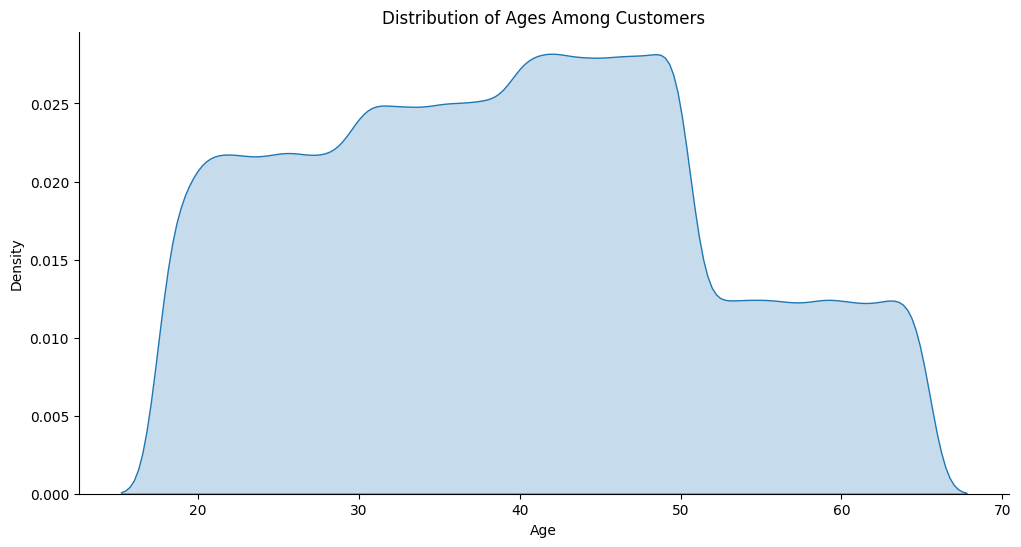

In [18]:
plt.figure(figsize=(12,6))
sns.kdeplot(data = df , x = df.Age , fill = True , common_norm=False)
plt.title('Distribution of Ages Among Customers')
sns.despine()
plt.show()

/tmp/ipykernel_228643/2187297696.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Age', data=df, palette='Set3')


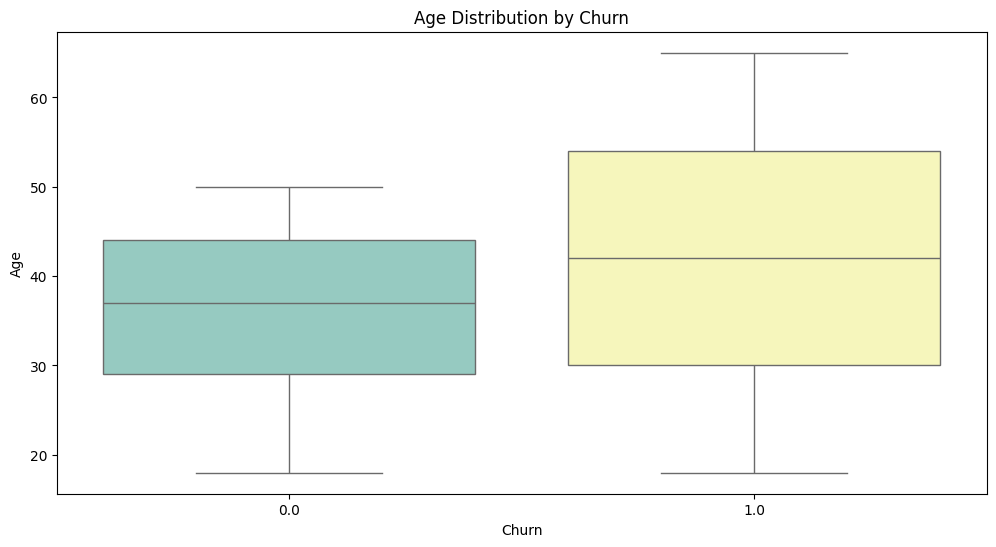

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='Age', data=df, palette='Set3')
plt.xlabel('Churn')
plt.ylabel('Age')
plt.title('Age Distribution by Churn')
plt.show()

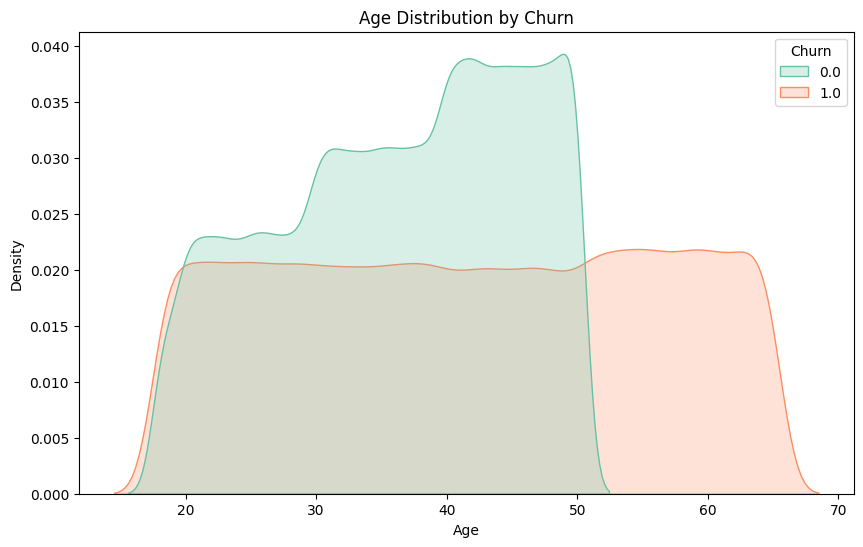

In [20]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Age', hue='Churn', common_norm=False, fill=True, palette='Set2')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution by Churn')
plt.show()

/tmp/ipykernel_228643/2442504112.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_churn_rate = df.groupby('AgeGroup')['Churn'].mean()
/tmp/ipykernel_228643/2442504112.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_churn_rate.index, y=age_churn_rate.values, palette='pastel')


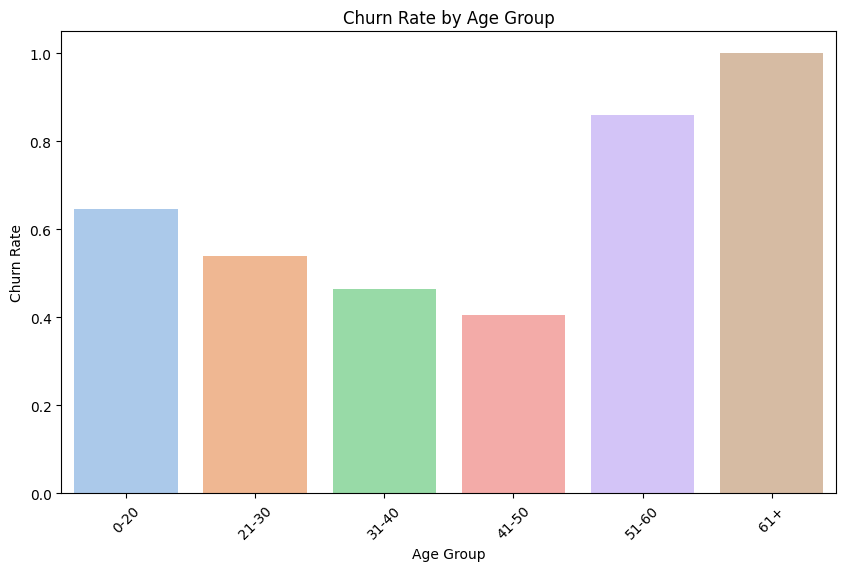

In [21]:
age_bins = [0, 20, 30, 40, 50, 60, float('inf')]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
age_churn_rate = df.groupby('AgeGroup')['Churn'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=age_churn_rate.index, y=age_churn_rate.values, palette='pastel')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Age Group')
plt.xticks(rotation=45)
plt.show()

    Age is normally distributed but is slighlty positively skewed which means we have more younger Customers

    We have a significant number of customers in the 40-50 age range, with a smaller but still substantial group in the 20-30 age range

    as you can see almost half of the customers in the 20-30 group Churn but the churn rate drops for the next age groups until 41-50 age group

    Everyone who is older than 60 Churn!!!


#### 2.Gender Analysis:

    What is the gender distribution of your customers?

    Is there any noticeable difference in churn rates between genders?

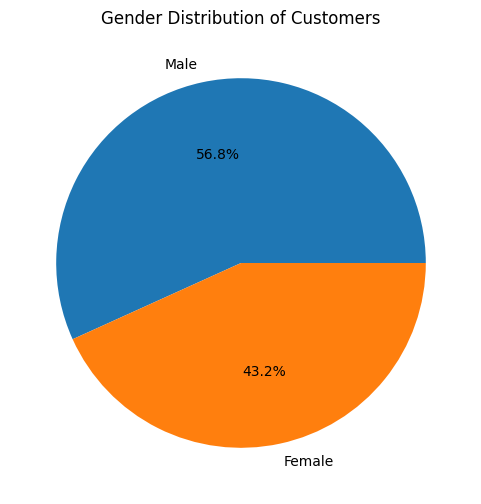

In [22]:
plt.figure(figsize=(6, 6))
gender_counts = df['Gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution of Customers')
plt.show()

/tmp/ipykernel_228643/2893446850.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_churn_rate.index, y=gender_churn_rate.values, palette='Set2')


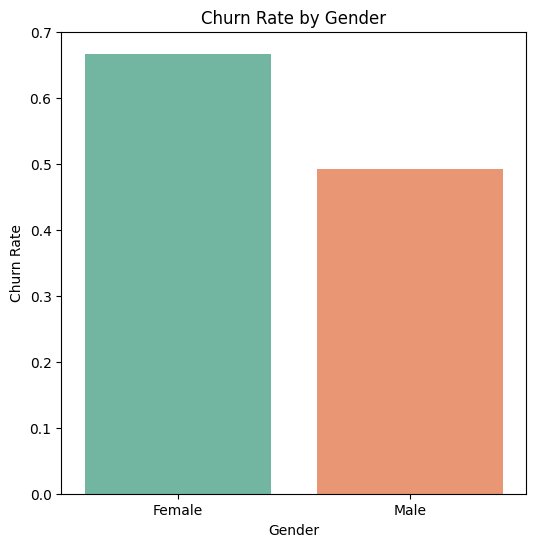

In [23]:
gender_churn_rate = df.groupby('Gender')['Churn'].mean()

plt.figure(figsize=(6, 6))
sns.barplot(x=gender_churn_rate.index, y=gender_churn_rate.values, palette='Set2')
plt.xlabel('Gender')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Gender')
plt.show()


    More than half of the customers are Male

    BUT The churn rate of the female customers are much higher than the male customers



#### 3.Tenure and Churn:

    How long, on average, have your customers been with your service (tenure)?

    Is there any pattern between tenure and churn?

/tmp/ipykernel_228643/1995513161.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tenure', y='Tenure', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette='Blues')


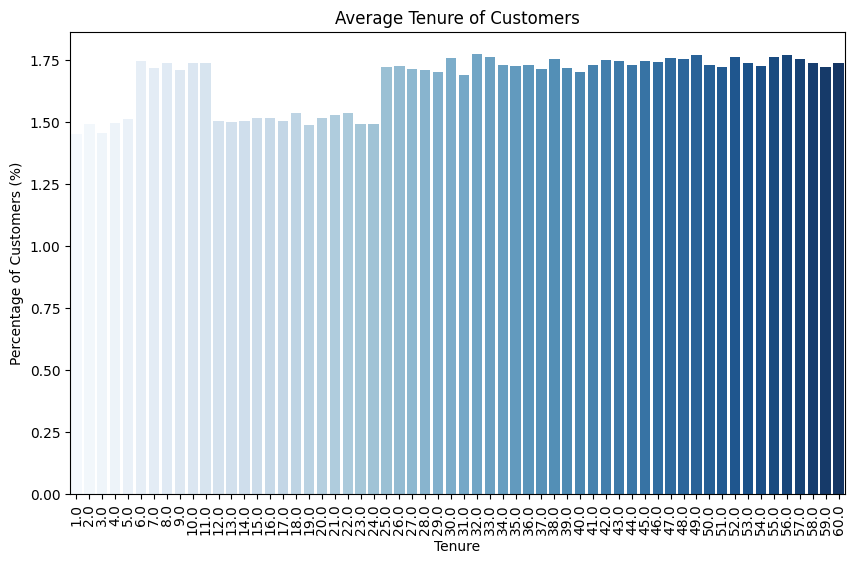

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Tenure', y='Tenure', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette='Blues')
plt.xlabel('Tenure')
plt.ylabel('Percentage of Customers (%)')
plt.title('Average Tenure of Customers')
plt.xticks(rotation=90)
plt.show()

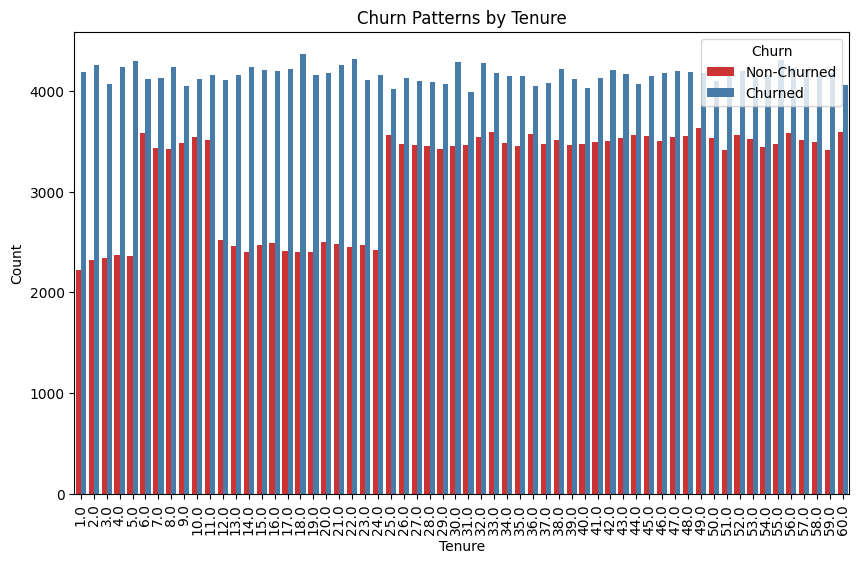

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Tenure', hue='Churn', data=df, palette='Set1')
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.title('Churn Patterns by Tenure')
plt.legend(title='Churn', labels=['Non-Churned', 'Churned'])
plt.xticks(rotation=90)
plt.show()

/tmp/ipykernel_228643/3125786845.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(x='Tenure', y='Churn', data=df, errorbar=None,  palette='Set2')


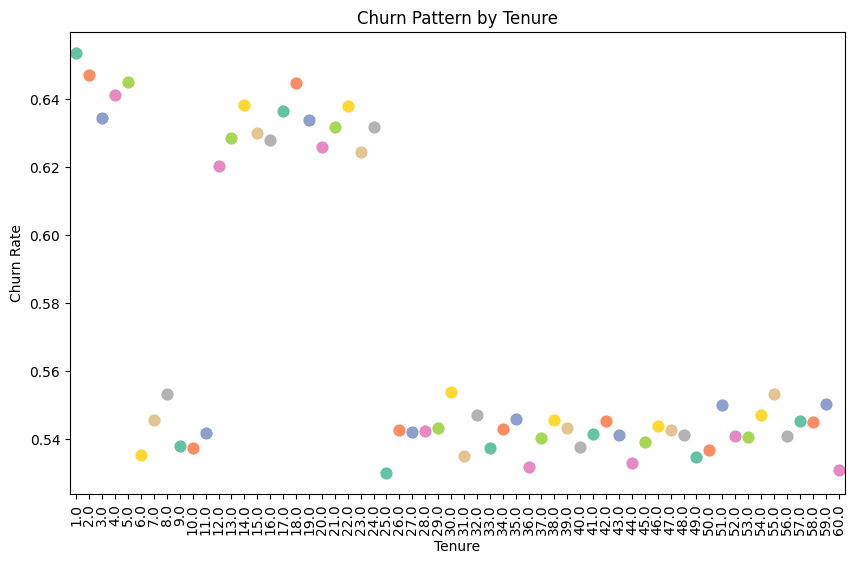

In [26]:
plt.figure(figsize=(10, 6))
sns.pointplot(x='Tenure', y='Churn', data=df, errorbar=None,  palette='Set2')
plt.xlabel('Tenure')
plt.ylabel('Churn Rate')
plt.title('Churn Pattern by Tenure')
plt.xticks(rotation=90)
plt.show()

    we can see that we have custmores with almost equally distributed Tenures

    the churn rate in new customers(1-5 tenure) and 12 to 24 month tenure is higher than others

    the churn rate for other customers is almost half


#### 4.Usage Frequency:

    How frequently do customers use your service, on average?

    Does usage frequency affect churn rates?

/tmp/ipykernel_228643/1743410065.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Usage_Frequency', y='Usage_Frequency', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette='Blues')


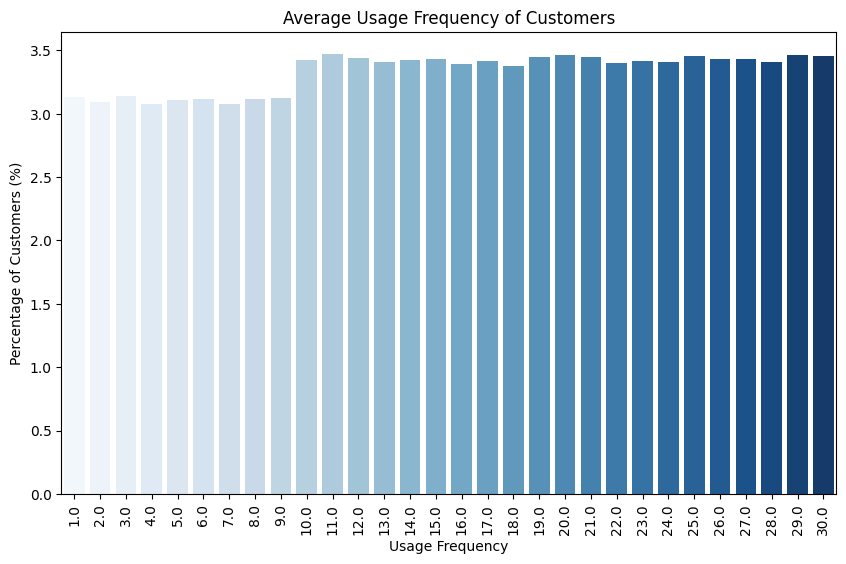

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Usage_Frequency', y='Usage_Frequency', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette='Blues')
plt.xlabel('Usage Frequency')
plt.ylabel('Percentage of Customers (%)')
plt.title('Average Usage Frequency of Customers')
plt.xticks(rotation=90)
plt.show()

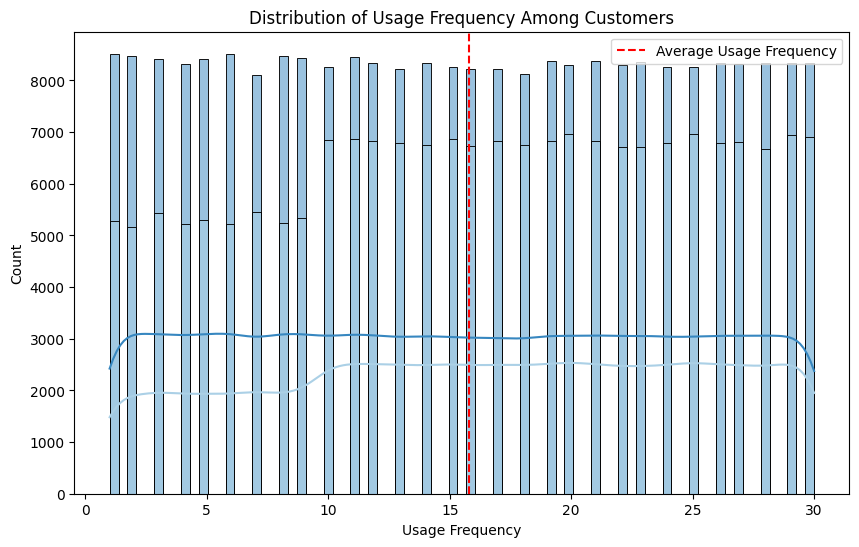

In [28]:
average_usage_frequency = df.Usage_Frequency.mean()
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Usage_Frequency',hue = 'Churn', kde=True, palette='Blues')
plt.axvline(average_usage_frequency, color='red', linestyle='dashed', label='Average Usage Frequency')
plt.xlabel('Usage Frequency')
plt.ylabel('Count')
plt.title('Distribution of Usage Frequency Among Customers')
plt.legend()
plt.show()

/tmp/ipykernel_228643/2964675461.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Churn', y='Usage_Frequency', data=df, palette='Set2')


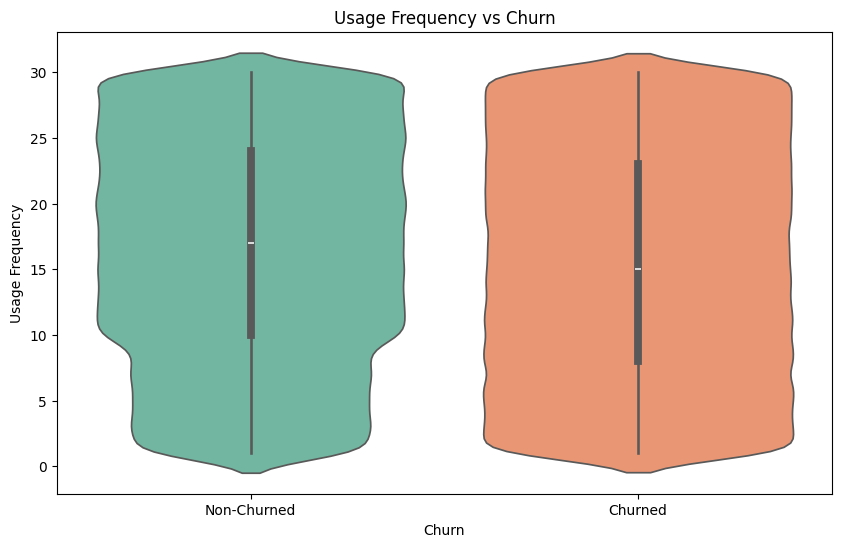

In [29]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Churn', y='Usage_Frequency', data=df, palette='Set2')
plt.xlabel('Churn')
plt.ylabel('Usage Frequency')
plt.title('Usage Frequency vs Churn')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.show()

    the 2 first plots show that usage frequency is flat and has a uniform distribution meaning that the customers usage is on average 15

    the usage freqeuncy does not seem to affect churn , only slightly lower churn rates for 0 - 10 usage frequency

#### 5.Support Calls and Churn :

    What is the average number of support calls made by customers?

    Is there any correlation between support calls and churn?

In [30]:
average_support_calls = df['Support_Calls'].mean()
print(f"Average Number of Support Calls: {average_support_calls}")

Average Number of Support Calls: 3.6044366107723578


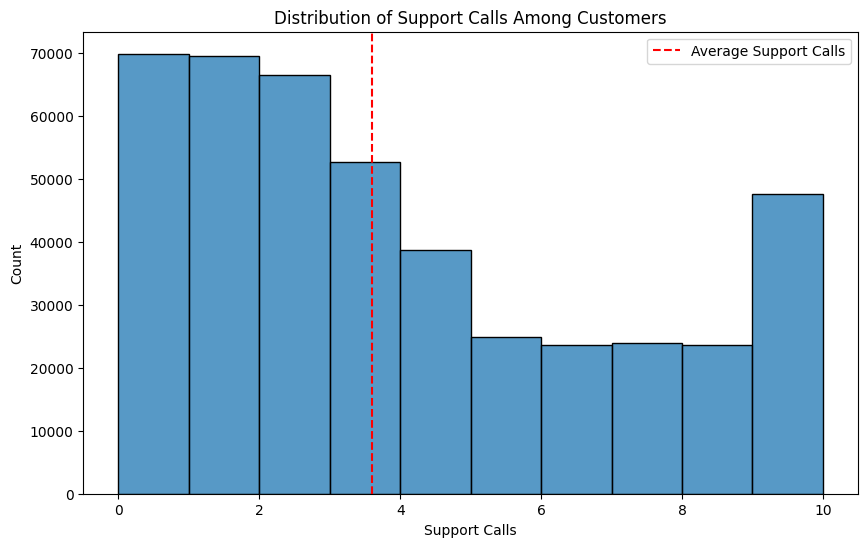

In [31]:
plt.figure(figsize = (10,6))
sns.histplot(data = df , x = 'Support_Calls' , bins = 10  )
plt.axvline(average_support_calls, color='red', linestyle='dashed', label='Average Support Calls')
plt.xlabel('Support Calls')
plt.ylabel('Count')
plt.title('Distribution of Support Calls Among Customers')
plt.legend()
plt.show()

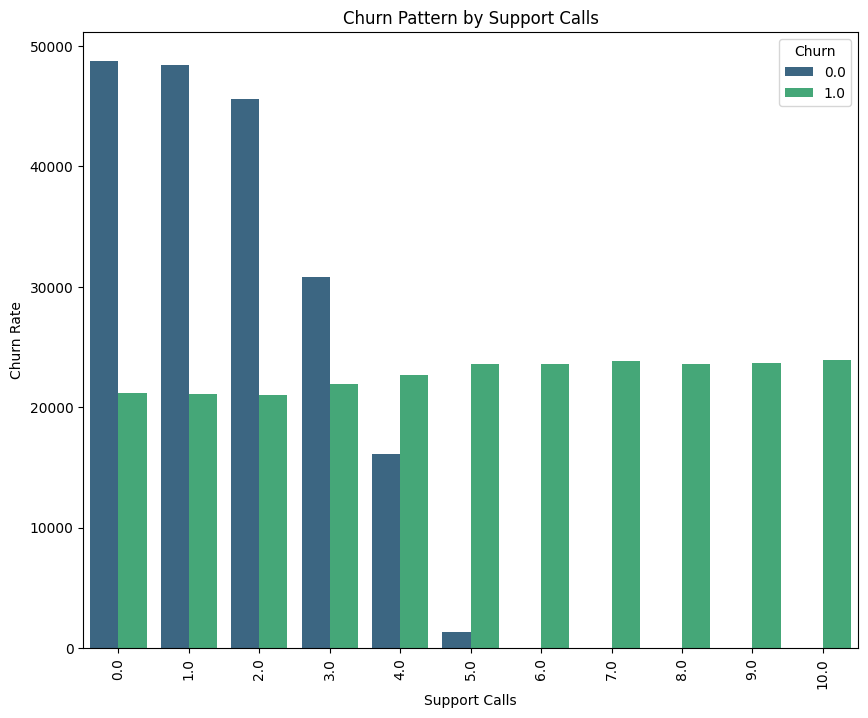

In [32]:
plt.figure(figsize = (10,8))
sns.countplot(data = df , x = 'Support_Calls' , hue = 'Churn', palette = 'viridis')
plt.xlabel('Support Calls')
plt.ylabel('Churn Rate')
plt.title('Churn Pattern by Support Calls')
plt.xticks(rotation=90)
plt.show()

    on average customers call the support 3 times

    support calls are much higher from 0 to 3 times for each customer and in this range the calls seem to be successful due to the churn rate of this customers

    as the support calls go higher the churn rates go higher too, to the point that for more than 5 calls there are no non churned customers and it seems the supporters are not successful in making the cutomer's problem go away



#### 6.Payment Delay :

    What is the typical payment delay among customers?

    Does payment delay influence churn behavior?


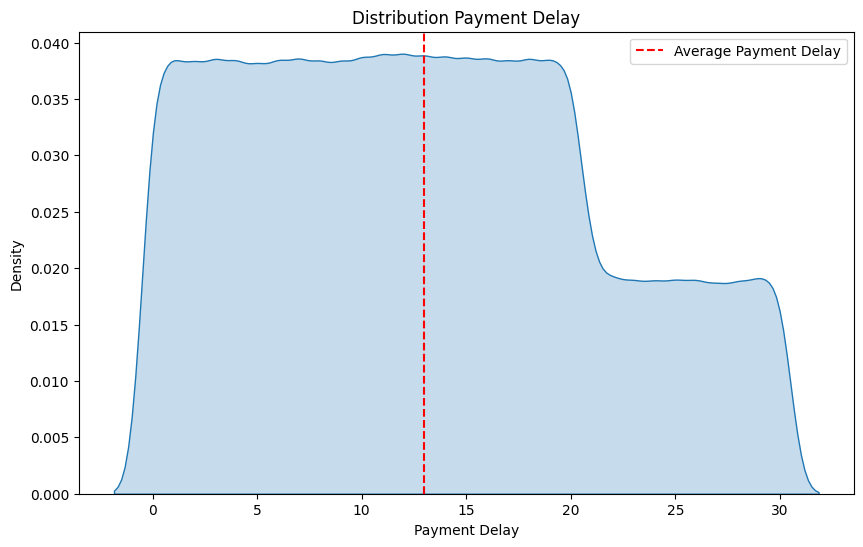

In [33]:
plt.figure(figsize = (10,6))
sns.kdeplot(data = df , x = 'Payment_Delay' , fill = True)
plt.title('Distribution Payment Delay')
avg_payment_delay = df.Payment_Delay.mean()
plt.xlabel('Payment Delay')
plt.axvline(avg_payment_delay , color = 'red' , linestyle = 'dashed' , label = 'Average Payment Delay')
plt.legend()
plt.show()

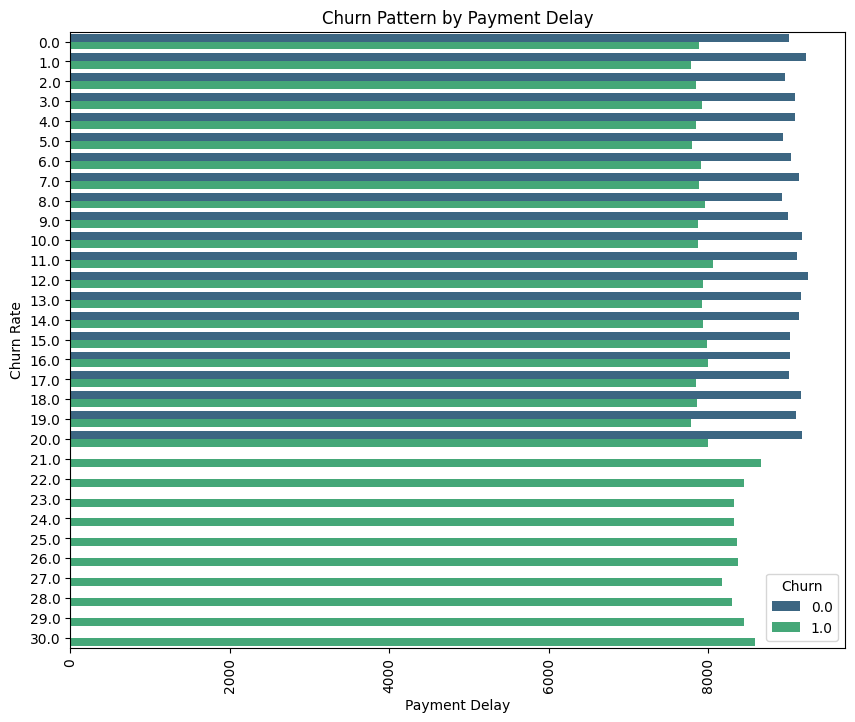

In [34]:
plt.figure(figsize = (10,8))
sns.countplot(data = df , y = 'Payment_Delay' , hue = 'Churn', palette = 'viridis')
plt.xlabel('Payment Delay')
plt.ylabel('Churn Rate')
plt.title('Churn Pattern by Payment Delay')
plt.xticks(rotation=90)
plt.show()


Answers :

    The payment Delay is normally distributed and slightly positively skewed

    the churn rate is too high from 0 to 20 but drops significantly after 20 month of payment delay



#### 7.Subscription Type and Contract Length

    What are the different subscription types and their proportions?

    Do customers with different subscription types have different churn rates?

    How does contract length relate to churn?



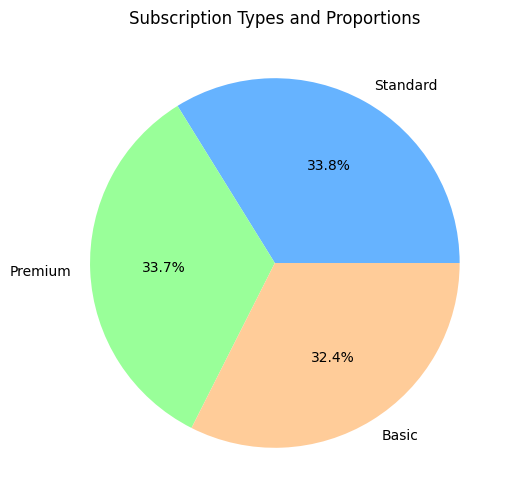

In [35]:
plt.figure(figsize=(6, 6))
subscription_counts = df['Subscription_Type'].value_counts()
plt.pie(subscription_counts, labels=subscription_counts.index, autopct='%1.1f%%', colors=['#66b3ff', '#99ff99', '#ffcc99'])
plt.title('Subscription Types and Proportions')
plt.show()

/tmp/ipykernel_228643/2476198504.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subscription_churn_rate.index, y=subscription_churn_rate.values, palette='pastel')


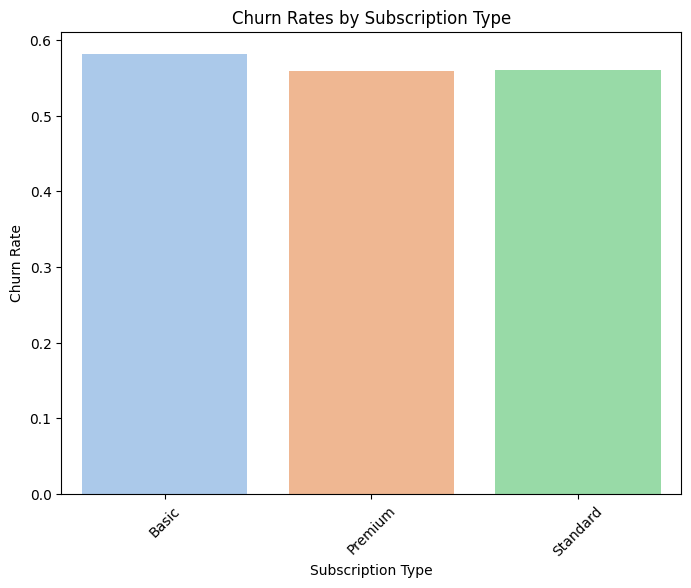

In [36]:
plt.figure(figsize=(8, 6))
subscription_churn_rate = df.groupby('Subscription_Type')['Churn'].mean()
sns.barplot(x=subscription_churn_rate.index, y=subscription_churn_rate.values, palette='pastel')
plt.xlabel('Subscription Type')
plt.ylabel('Churn Rate')
plt.title('Churn Rates by Subscription Type')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_228643/1480949907.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Contract_Length', y='Churn', data=df, palette='Set3')


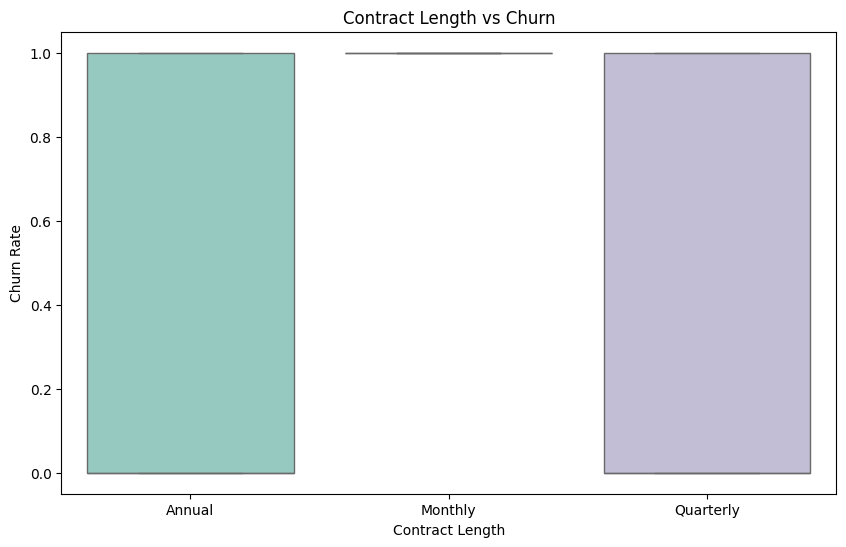

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Contract_Length', y='Churn', data=df, palette='Set3')
plt.xlabel('Contract Length')
plt.ylabel('Churn Rate')
plt.title('Contract Length vs Churn')

plt.show()

In [38]:
df[(df['Contract_Length'] == 'Monthly') & (df['Churn'] == 0)]

Empty DataFrame
Columns: [Age, Gender, Tenure, Usage_Frequency, Support_Calls, Payment_Delay, Subscription_Type, Contract_Length, Total_Spend, Last_Interaction, Churn, AgeGroup]
Index: []


Answers :

    The subscription types have eqaul proportions of the data

    The churn rate among the subscription types is also equal

    almost half of customers with annual and quarterly contracts churn, but customers with monthly contracts all churn




#### 8.Total Spend and Churn

    What is the average total spend of customers?

    Is there any correlation between total spend and churn?
    

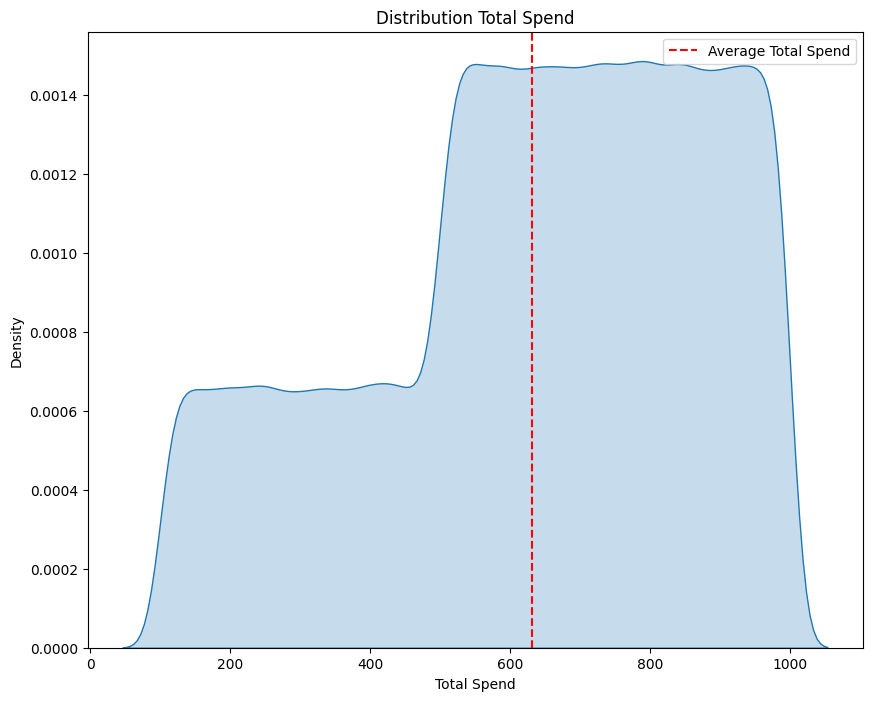

In [39]:
plt.figure(figsize = (10,8))
sns.kdeplot(data = df , x = 'Total_Spend' , fill = True )
plt.title('Distribution Total Spend')
avg_total_spend = df.Total_Spend.mean()
plt.xlabel('Total Spend')
plt.axvline(avg_total_spend , color = 'red' , linestyle = 'dashed' , label = 'Average Total Spend')
plt.legend()
plt.show()

/tmp/ipykernel_228643/3676826545.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Total_Spend', data=df, palette='Set2')


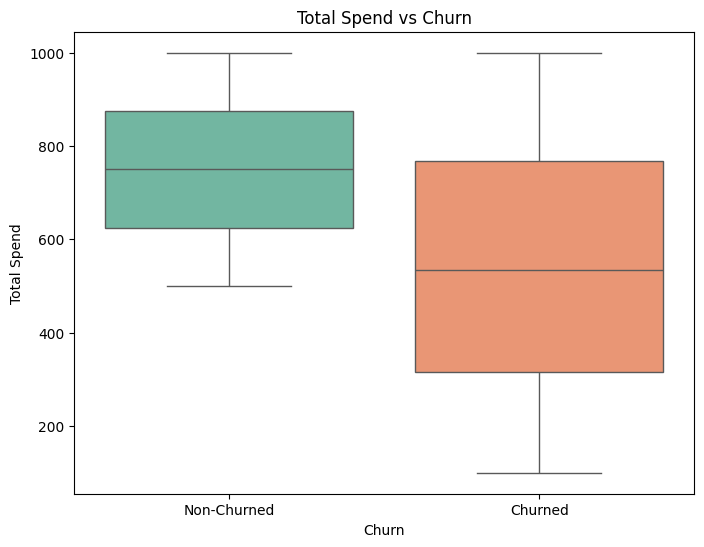

In [40]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='Total_Spend', data=df, palette='Set2')
plt.xlabel('Churn')
plt.ylabel('Total Spend')
plt.title('Total Spend vs Churn')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.show()

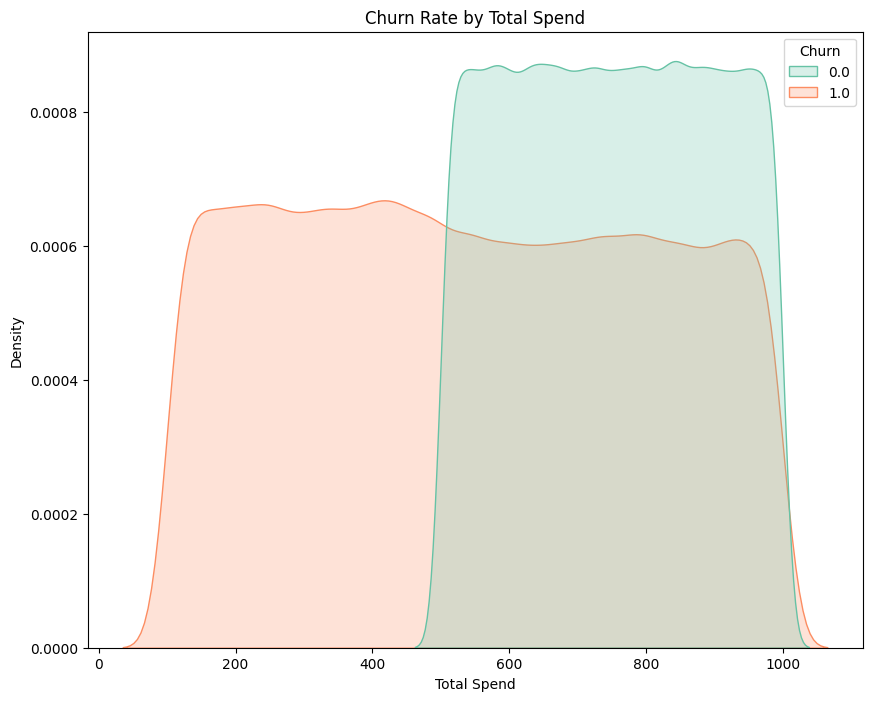

In [41]:
plt.figure(figsize = (10,8))
sns.kdeplot(data = df , x = 'Total_Spend' ,hue = 'Churn', fill = True , palette = 'Set2')
plt.title('Churn Rate by Total Spend')
plt.xlabel('Total Spend')
plt.show()


Answers :

    each customer on average spends about 650$

    most customers with who spend more than 500$ tend not to churn



#### 9.Last Interaction

    How recently did customers interact with your service?

    Is there any connection between the recency of the last interaction and churn?



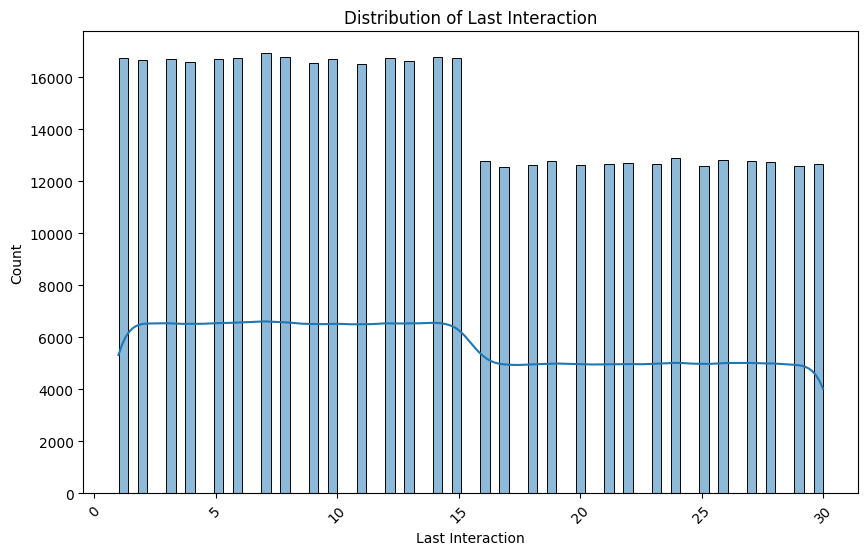

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Last_Interaction', kde=True)
plt.xlabel('Last Interaction')
plt.ylabel('Count')
plt.title('Distribution of Last Interaction')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_228643/3614262196.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Churn', y='Last_Interaction', data=df, palette='Set3')


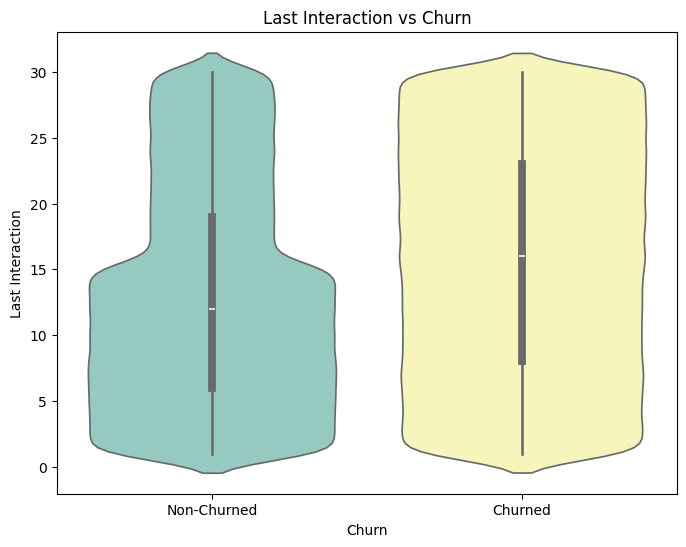

In [43]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='Churn', y='Last_Interaction', data=df, palette='Set3')
plt.xlabel('Churn')
plt.ylabel('Last Interaction')
plt.title('Last Interaction vs Churn')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.show()


Answers :

    Last ineteraction of customers has a uniform disribution but just slightly higher from 0 to 15

    the churn rate by last inetraction shows no significant differennce so last inetraction has no or little impact on churn rate




#### 10.Churn Analysis (Target Variable)

    What is the overall churn rate in your dataset?


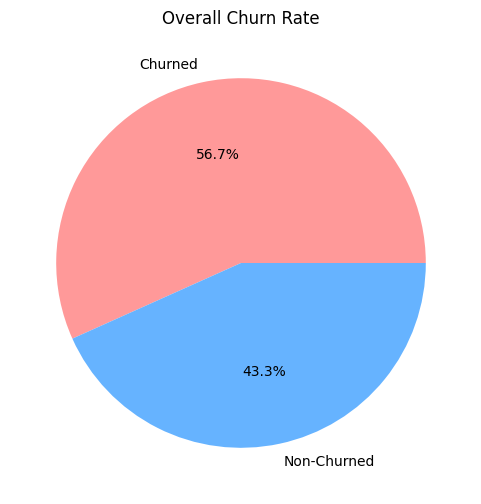

In [44]:
overall_churn_rate = df['Churn'].mean() * 100

plt.figure(figsize=(6, 6))
plt.pie([overall_churn_rate, 100 - overall_churn_rate], labels=['Churned', 'Non-Churned'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Overall Churn Rate')
plt.show()

/tmp/ipykernel_228643/2902409759.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette='viridis')


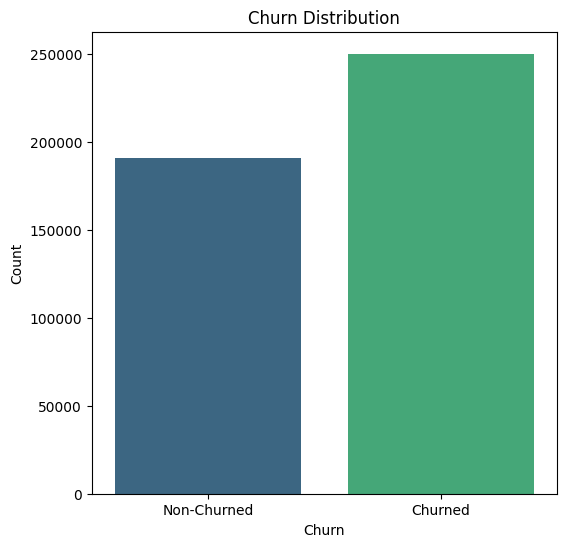

In [45]:
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='Churn', palette='viridis')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Churn Distribution')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.show()


Answers :

    by analysing the target variable (Churn) we can see that most customers of our shop are churning!



#### 11.Correlations

    Are there any notable correlations between different features and churn?

    Could multicollinearity between features affect your analysis?


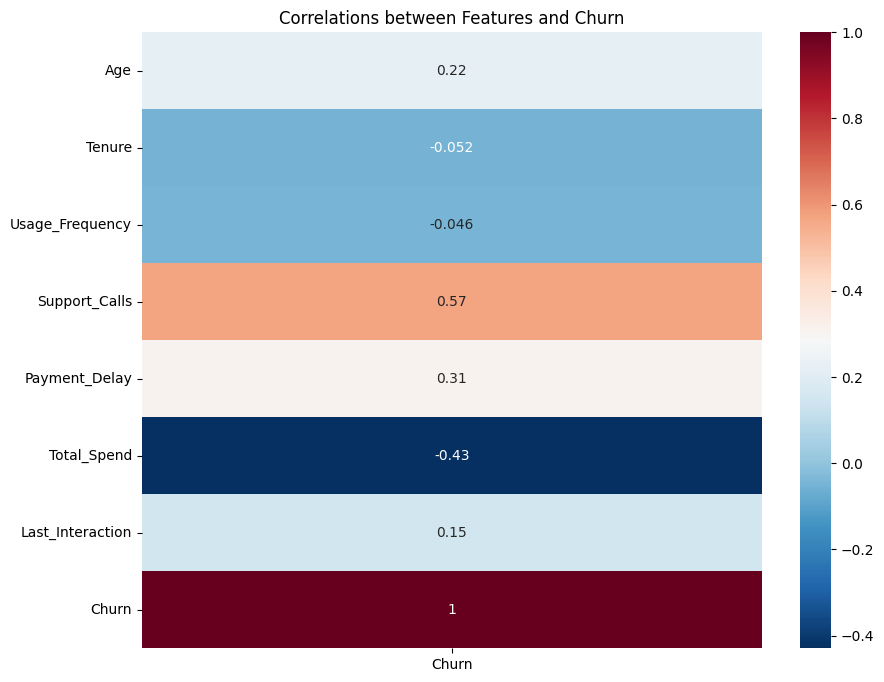

In [46]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['Churn']], annot=True, cmap='RdBu_r')
plt.title('Correlations between Features and Churn')
plt.show()

/tmp/ipykernel_228643/1792648328.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_corr_vars, y=high_corr_values, palette='RdBu_r')


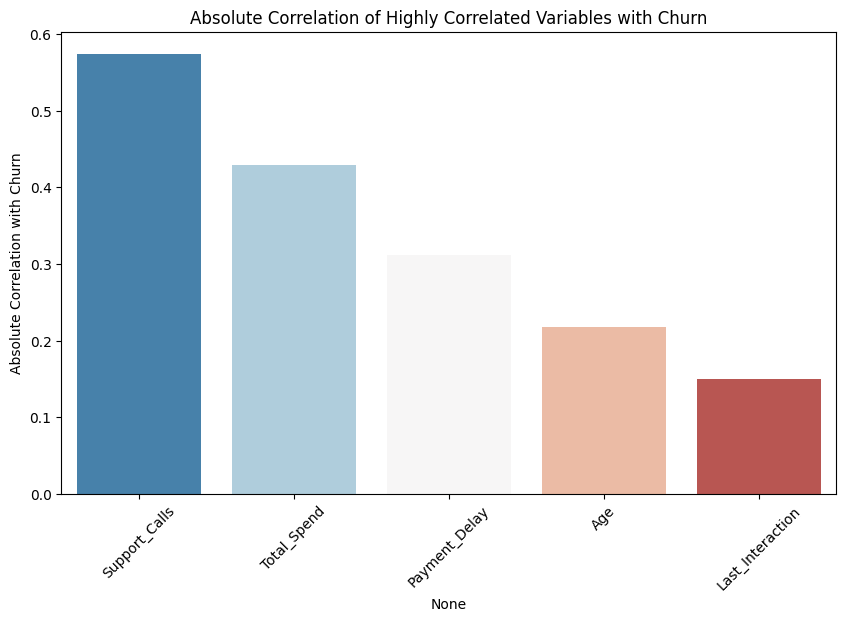

In [47]:
high_corr_vars = corr_matrix.abs().nlargest(6, 'Churn')['Churn'].index[1:]
high_corr_values = corr_matrix.abs().nlargest(6, 'Churn')['Churn'].values[1:]

plt.figure(figsize=(10, 6))
sns.barplot(x=high_corr_vars, y=high_corr_values, palette='RdBu_r')
plt.ylabel('Absolute Correlation with Churn')
plt.title('Absolute Correlation of Highly Correlated Variables with Churn')
plt.xticks(rotation=45)
plt.show()

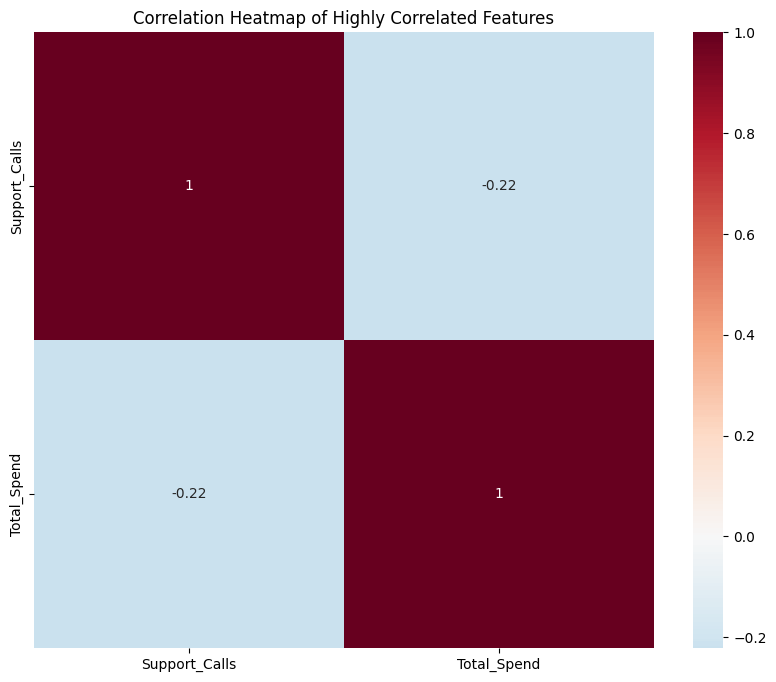

In [48]:
corr_matrix = df.drop(columns=['Churn']).corr(numeric_only=True)

high_corr_features = []
for column in corr_matrix.columns:
    max_corr = corr_matrix[column].drop(index=column).abs().max()
    if max_corr > 0.2:
        high_corr_features.append(column)

plt.figure(figsize=(10, 8))
sns.heatmap(df[high_corr_features].corr(), annot=True, cmap='RdBu_r', center=0)
plt.title('Correlation Heatmap of Highly Correlated Features')
plt.show()


Answers :

    from the first plot we realize that support calls feature has the highest correlation with Churn

    The second plot shows the features that have the highest correlation with the target variable (Churn)

    The third plot shows the highly correlated features except for Churn



In [49]:
df

Age  Gender  Tenure  Usage_Frequency  Support_Calls  Payment_Delay  \
0       30.0  Female    39.0             14.0            5.0           18.0   
1       65.0  Female    49.0              1.0           10.0            8.0   
2       55.0  Female    14.0              4.0            6.0           18.0   
3       58.0    Male    38.0             21.0            7.0            7.0   
4       23.0    Male    32.0             20.0            5.0            8.0   
...      ...     ...     ...              ...            ...            ...   
440827  42.0    Male    54.0             15.0            1.0            3.0   
440828  25.0  Female     8.0             13.0            1.0           20.0   
440829  26.0    Male    35.0             27.0            1.0            5.0   
440830  28.0    Male    55.0             14.0            2.0            0.0   
440831  31.0    Male    48.0             20.0            1.0           14.0   

       Subscription_Type Contract_Length  Total_Spend  Last_Interaction  \
0               Standard          Annual       932.00              17.0   
1                  Basic         Monthly       557.00               6.0   
2                  Basic       Quarterly       185.00               3.0   
3               Standard         Monthly       396.00              29.0   
4                  Basic         Monthly       617.00              20.0   
...                  ...             ...          ...               ...   
440827           Premium          Annual       716.38               8.0   
440828           Premium          Annual       745.38               2.0   
440829          Standard       Quarterly       977.31               9.0   
440830          Standard       Quarterly       602.55               2.0   
440831           Premium       Quarterly       567.77              21.0   

        Churn AgeGroup  
0         1.0    31-40  
1         1.0      61+  
2         1.0    51-60  
3         1.0    51-60  
4         1.0    21-30  
...       ...      ...  
440827    0.0    41-50  
440828    0.0    21-30  
440829    0.0    21-30  
440830    0.0    21-30  
440831    0.0    31-40  

[440832 rows x 12 columns]

In [50]:
joblib.dump(df, f'../datasets/processed_data.pkl')

['../datasets/processed_data.pkl']

# =============================================
# ENHANCED FEATURE ENGINEERING BASED ON EDA
# =============================================

In [51]:
def preprocess(df):
    
    df = df.drop(columns=['CustomerID'], errors='ignore')
    df = df.rename(columns=lambda x: x.replace(' ', '_'))
    
    # 1. Age Features (from EDA: 20-30 and >60 have highest churn)
    df['AgeGroup'] = pd.cut(df['Age'], 
                        bins=[0, 20, 30, 40, 50, 60, float('inf')],
                        labels=['0-20', '21-30', '31-40', '41-50', '51-60', '61+'])
    df['Is_Young_Adult'] = (df['Age'].between(20, 30)).astype(int)
    df['Is_Senior'] = (df['Age'] > 60).astype(int)

    # 2. Tenure Features (from EDA: new customers and 12-24 month tenure churn more)
    df['TenureGroup'] = pd.cut(df['Tenure'], 
                              bins=[0, 5, 12, 24, 36, float('inf')], 
                              labels=['0-5', '6-12', '13-24', '25-36', '37+'])
    df['Is_New_Customer'] = (df['Tenure'] <= 5).astype(int)
    df['Is_Mid_Tenure'] = (df['Tenure'].between(12, 24)).astype(int)

    # 3. Support Call Features (from EDA: >5 calls = 100% churn)
    df['High_Support_Calls'] = (df['Support_Calls'] > 5).astype(int)
    df['Medium_Support_Calls'] = ((df['Support_Calls'] > 3) & (df['Support_Calls'] <= 5)).astype(int)
    df['Support_Calls_per_Usage'] = df['Support_Calls'] / (df['Usage_Frequency'] + 0.1)

    # 4. Payment Delay Features (from EDA: 0-20 month delay has high churn)
    df['Payment_Delay_Group'] = pd.cut(df['Payment_Delay'], 
                                 bins=[-1, 5, 20, float('inf')], 
                                 labels=['0-5', '6-20', '21+'])
    df['Has_Payment_Delay_Issue'] = (df['Payment_Delay'] <= 20).astype(int)

    # 5. Gender Features (from EDA: Females churn more)
    df['Is_Female'] = (df['Gender'] == 'Female').astype(int)
    df['Female_High_Support'] = ((df['Gender'] == 'Female') & (df['Support_Calls'] > 3)).astype(int)

    # 6. Subscription Features (from EDA: Monthly contracts all churn)
    df['Is_Monthly_Contract'] = (df['Contract_Length'] == 'Monthly').astype(int)

    # 7. Total Spend Features (from EDA: >$500 spend less likely to churn)
    df['Is_High_Spender'] = (df['Total_Spend'] > 500).astype(int)

    return df

In [52]:
train_df = preprocess(df)
test_df = preprocess(test_df)

In [53]:
train_df

Age  Gender  Tenure  Usage_Frequency  Support_Calls  Payment_Delay  \
0       30.0  Female    39.0             14.0            5.0           18.0   
1       65.0  Female    49.0              1.0           10.0            8.0   
2       55.0  Female    14.0              4.0            6.0           18.0   
3       58.0    Male    38.0             21.0            7.0            7.0   
4       23.0    Male    32.0             20.0            5.0            8.0   
...      ...     ...     ...              ...            ...            ...   
440827  42.0    Male    54.0             15.0            1.0            3.0   
440828  25.0  Female     8.0             13.0            1.0           20.0   
440829  26.0    Male    35.0             27.0            1.0            5.0   
440830  28.0    Male    55.0             14.0            2.0            0.0   
440831  31.0    Male    48.0             20.0            1.0           14.0   

       Subscription_Type Contract_Length  Total_Spend  Last_Interaction  ...  \
0               Standard          Annual       932.00              17.0  ...   
1                  Basic         Monthly       557.00               6.0  ...   
2                  Basic       Quarterly       185.00               3.0  ...   
3               Standard         Monthly       396.00              29.0  ...   
4                  Basic         Monthly       617.00              20.0  ...   
...                  ...             ...          ...               ...  ...   
440827           Premium          Annual       716.38               8.0  ...   
440828           Premium          Annual       745.38               2.0  ...   
440829          Standard       Quarterly       977.31               9.0  ...   
440830          Standard       Quarterly       602.55               2.0  ...   
440831           Premium       Quarterly       567.77              21.0  ...   

        Is_Mid_Tenure High_Support_Calls  Medium_Support_Calls  \
0                   0                  0                     1   
1                   0                  1                     0   
2                   1                  1                     0   
3                   0                  1                     0   
4                   0                  0                     1   
...               ...                ...                   ...   
440827              0                  0                     0   
440828              0                  0                     0   
440829              0                  0                     0   
440830              0                  0                     0   
440831              0                  0                     0   

        Support_Calls_per_Usage Payment_Delay_Group  Has_Payment_Delay_Issue  \
0                      0.354610                6-20                        1   
1                      9.090909                6-20                        1   
2                      1.463415                6-20                        1   
3                      0.331754                6-20                        1   
4                      0.248756                6-20                        1   
...                         ...                 ...                      ...   
440827                 0.066225                 0-5                        1   
440828                 0.076336                6-20                        1   
440829                 0.036900                 0-5                        1   
440830                 0.141844                 0-5                        1   
440831                 0.049751                6-20                        1   

        Is_Female  Female_High_Support  Is_Monthly_Contract  Is_High_Spender  
0               1                    1                    0                1  
1               1                    1                    1                1  
2               1                    1                    0                0  
3               0            

In [54]:
test_df

Age  Gender  Tenure  Usage_Frequency  Support_Calls  Payment_Delay  \
0       22  Female      25               14              4             27   
1       41  Female      28               28              7             13   
2       47    Male      27               10              2             29   
3       35    Male       9               12              5             17   
4       53  Female      58               24              9              2   
...    ...     ...     ...              ...            ...            ...   
64369   45  Female      33               12              6             21   
64370   37    Male       6                1              5             22   
64371   25    Male      39               14              8             30   
64372   50  Female      18               19              7             22   
64373   52  Female      45               15              9             25   

      Subscription_Type Contract_Length  Total_Spend  Last_Interaction  ...  \
0                 Basic         Monthly          598                 9  ...   
1              Standard         Monthly          584                20  ...   
2               Premium          Annual          757                21  ...   
3               Premium       Quarterly          232                18  ...   
4              Standard          Annual          533                18  ...   
...                 ...             ...          ...               ...  ...   
64369             Basic       Quarterly          947                14  ...   
64370          Standard          Annual          923                 9  ...   
64371           Premium         Monthly          327                20  ...   
64372          Standard         Monthly          540                13  ...   
64373          Standard         Monthly          696                22  ...   

       Is_Mid_Tenure High_Support_Calls  Medium_Support_Calls  \
0                  0                  0                     1   
1                  0                  1                     0   
2                  0                  0                     0   
3                  0                  0                     1   
4                  0                  1                     0   
...              ...                ...                   ...   
64369              0                  1                     0   
64370              0                  0                     1   
64371              0                  1                     0   
64372              1                  1                     0   
64373              0                  1                     0   

       Support_Calls_per_Usage Payment_Delay_Group  Has_Payment_Delay_Issue  \
0                     0.283688                 21+                        0   
1                     0.249110                6-20                        1   
2                     0.198020                 21+                        0   
3                     0.413223                6-20                        1   
4                     0.373444                 0-5                        1   
...                        ...                 ...                      ...   
64369                 0.495868                 21+                        0   
64370                 4.545455                 21+                        0   
64371                 0.567376                 21+                        0   
64372                 0.366492                 21+                        0   
64373                 0.596026                 21+                        0   

       Is_Female  Female_High_Support  Is_Monthly_Contract  Is_High_Spender  
0              1                    1                    1                1  
1              1                    1                    1                1  
2              0                    0                    0                1  
3              0                    0                    0                0  
4            

In [55]:
joblib.dump(train_df,f'../datasets/data_for_modeling.pkl')

['../datasets/data_for_modeling.pkl']

In [56]:
test_df.to_csv('../datasets/processed_test_data.csv', index=False)

# =============================================
# MODELING SETUP
# =============================================

In [57]:
# Split data into train and validation sets for early stopping
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop('Churn', axis=1),
    train_df['Churn'],
    test_size=0.2,
    random_state=42,
    stratify=train_df['Churn']
)

X_test = test_df.drop('Churn', axis=1)  # Use the actual test set
y_test = test_df['Churn']

In [58]:
# Verify Test Set Compatibility

assert set(X_train.columns) == set(X_test.columns)
assert not X_test.isnull().any().any()

In [59]:
# training and testing data distribution

train_test_distribution = pd.concat([
    train_df['Churn'].value_counts(normalize=True).rename('Train'),
    test_df['Churn'].value_counts(normalize=True).rename('Test')
], axis=1)
print(train_test_distribution)

          Train      Test
Churn                    
1.0    0.567107  0.473685
0.0    0.432893  0.526315


In [60]:
list(train_df.columns)

['Age',
 'Gender',
 'Tenure',
 'Usage_Frequency',
 'Support_Calls',
 'Payment_Delay',
 'Subscription_Type',
 'Contract_Length',
 'Total_Spend',
 'Last_Interaction',
 'Churn',
 'AgeGroup',
 'Is_Young_Adult',
 'Is_Senior',
 'TenureGroup',
 'Is_New_Customer',
 'Is_Mid_Tenure',
 'High_Support_Calls',
 'Medium_Support_Calls',
 'Support_Calls_per_Usage',
 'Payment_Delay_Group',
 'Has_Payment_Delay_Issue',
 'Is_Female',
 'Female_High_Support',
 'Is_Monthly_Contract',
 'Is_High_Spender']

In [61]:
# Define preprocessing steps
numeric_features = ['Age', 'Tenure', 'Usage_Frequency', 'Support_Calls', 
                   'Payment_Delay', 'Total_Spend', 'Last_Interaction',
                   'Is_Young_Adult', 'Is_Senior', 'Is_New_Customer', 
                   'Is_Mid_Tenure', 'High_Support_Calls', 'Medium_Support_Calls',
                   'Support_Calls_per_Usage', 'Has_Payment_Delay_Issue',
                   'Is_Female', 'Female_High_Support', 'Is_Monthly_Contract',
                   'Is_High_Spender']

In [62]:
categorical_features = ['Gender', 'Subscription_Type', 'Contract_Length', 
                       'AgeGroup', 'TenureGroup', 'Payment_Delay_Group']

In [63]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [64]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [65]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        random_state=42,
        eval_metric='aucpr',
        scale_pos_weight=2.0,
        early_stopping_rounds=10,
        enable_categorical=True,
        tree_method='hist'
    ))
])


In [66]:
# Define hyperparameters for tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 7],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': [0, 0.2]
}

In [67]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3
)

In [68]:
# Pre-fit the preprocessor separately
preprocessor.fit(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

grid_search.fit(
    X_train, y_train,
    classifier__eval_set=[(X_val_transformed, y_val)],
    classifier__verbose=True
)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[0]	validation_0-aucpr:0.82720
[0]	validation_0-aucpr:0.78168
[1]	validation_0-aucpr:0.98228
[1]	validation_0-aucpr:0.97721
[2]	validation_0-aucpr:0.98228
[2]	validation_0-aucpr:0.98234
[3]	validation_0-aucpr:0.98228
[3]	validation_0-aucpr:0.98234
[4]	validation_0-aucpr:0.98228
[4]	validation_0-aucpr:0.98234
[5]	validation_0-aucpr:0.98228
[5]	validation_0-aucpr:0.98234
[6]	validation_0-aucpr:0.98228
[6]	validation_0-aucpr:0.98234
[7]	validation_0-aucpr:0.98228
[7]	validation_0-aucpr:0.98463
[8]	validation_0-aucpr:0.98228
[8]	validation_0-aucpr:0.98463
[9]	validation_0-aucpr:0.98457
[9]	validation_0-aucpr:0.98463
[10]	validation_0-aucpr:0.98457
[10]	validation_0-aucpr:0.98463
[0]	validation_0-aucpr:0.98905
[11]	validation_0-aucpr:0.98709
[1]	validation_0-aucpr:0.98910
[11]	validation_0-aucpr:0.98463
[0]	validation_0-aucpr:0.78168
[12]	validation_0-aucpr:0.98463
[2]	validation_0-aucpr:0.98974
[12]	validation_0-aucpr:0.98902
[1

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Tenure',
                                                                          'Usage_Frequency',
                                                                          'Support_Calls',
                                                                          'Payment_Delay',
                                                                          'Total_Spend',
                                                                          'Last_Interaction',
                                                                          'Is_Young_Adult',
                                                                          'Is_Senior',
                                                                          'Is_New_Customer',
                                                                          'Is_Mid_Tenure',
                                                                          'High_Support_Calls',
                                                                          'Medium_Support_Calls'...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__gamma': [0, 0.2],
                         'classifier__learning_rate': [0.05, 0.1],
                         'classifier__max_depth': [5, 7],
                         'classifier__n_estimators': [100, 200],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=3)

# =============================================
# MODEL EVALUATION
# =============================================

In [69]:
# Get the best model
best_model = grid_search.best_estimator_

In [70]:
joblib.dump(best_model, '../models/churn_model.pkl')

['../models/churn_model.pkl']

In [73]:
# store the model
# model_version = datetime.datetime.now().strftime("%Y%m%d_%H%M")
# joblib.dump(best_model, f'../models/churn_v{model_version}.pkl')

# Add metadata to saved model:
joblib.dump({
    'model': best_model,
    'timestamp': datetime.datetime.now(),
    'git_hash': os.popen('git rev-parse HEAD').read().strip()
}, 'model_with_metadata.pkl')

fatal: not a git repository (or any of the parent directories): .git


['model_with_metadata.pkl']

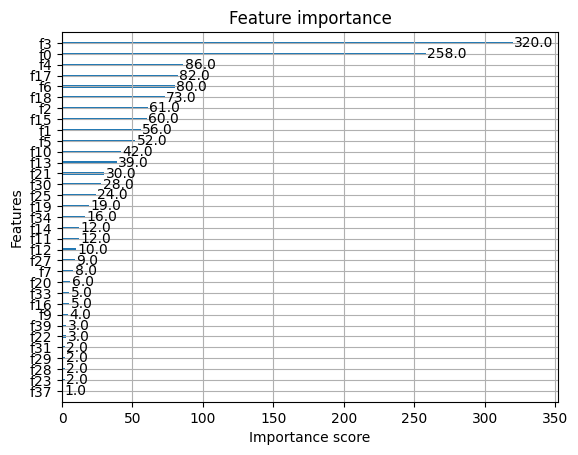

In [74]:
xgb.plot_importance(best_model.named_steps['classifier'])
plt.show()

In [75]:
# Evaluate on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [76]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [77]:
print(f"Best Parameters: {grid_search.best_params_}")
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.2, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}

Model Evaluation Metrics:
Accuracy: 0.5032
Precision: 0.4881
Recall: 0.9987
F1 Score: 0.6557
ROC AUC: 0.7383


In [78]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374



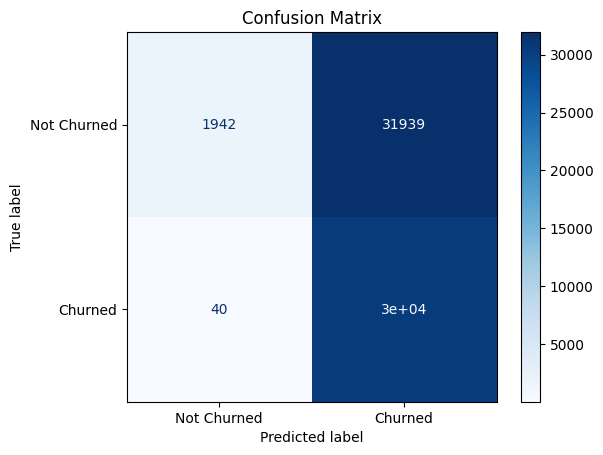

In [79]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churned', 'Churned'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [80]:
# Feature importance
preprocessor = best_model.named_steps['preprocessor']
feature_names = numeric_features.copy()

In [81]:
# Add one-hot encoded categorical feature names
ohe_columns = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
feature_names.extend(ohe_columns)

In [82]:
# Get feature importances
importances = best_model.named_steps['classifier'].feature_importances_

In [83]:
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

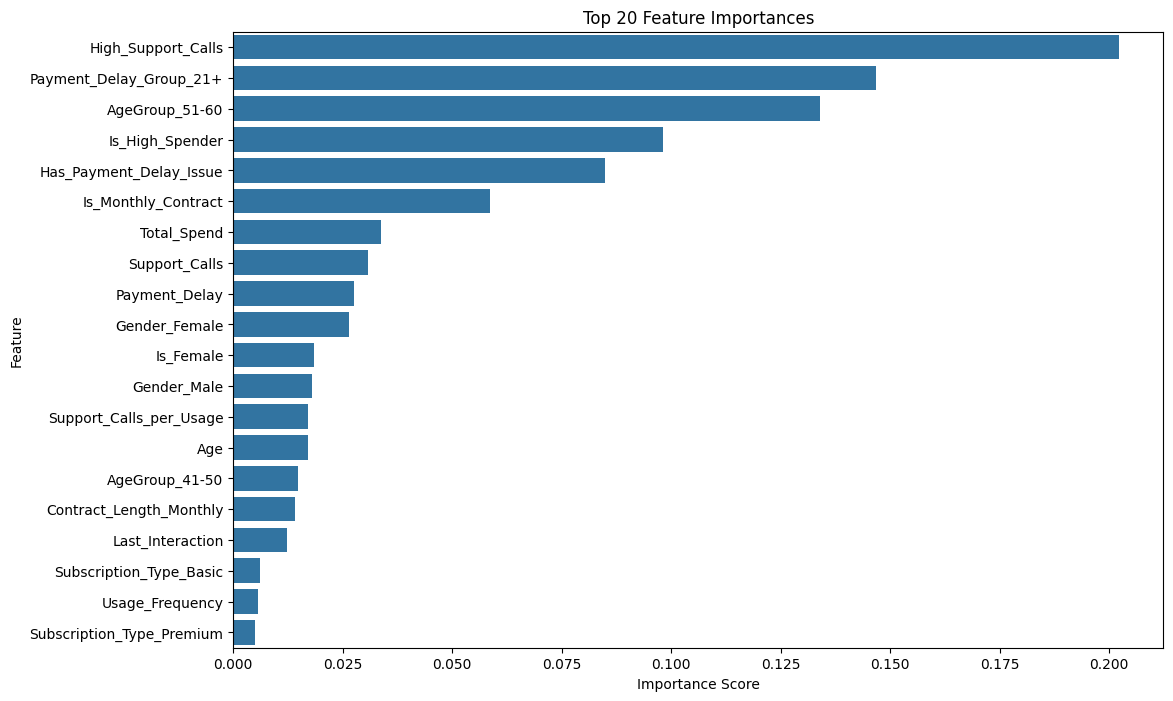

In [84]:
# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# =============================================
# VALIDATE KEY EDA INSIGHTS IN MODEL
# =============================================

## 1. High support calls (>5 should predict churn)

In [85]:
high_support_mask = X_test['Support_Calls'] > 5

print("\n=== Key Insight Validation ===")
if high_support_mask.any():
    print(f"\nAccuracy on High Support Calls (>5): {accuracy_score(y_test[high_support_mask], y_pred[high_support_mask]):.2f}")
    print(f"Churn Rate in High Support Calls: {y_test[high_support_mask].mean():.2f}")
    print(f"Model Predicted Churn Rate: {y_pred[high_support_mask].mean():.2f}")


=== Key Insight Validation ===

Accuracy on High Support Calls (>5): 0.61
Churn Rate in High Support Calls: 0.61
Model Predicted Churn Rate: 1.00


## 2. Age group 20-30 and >60

In [86]:
for age_range, condition in [('20-30', X_test['Age'].between(20, 30)),
                             ('60+', X_test['Age'] > 60)]:
    if condition.any():
        print(f"\n{age_range} Age Group:")
        print(f"Actual Churn Rate: {y_test[condition].mean():.2f}")
        print(f"Model Recall: {recall_score(y_test[condition], y_pred[condition]):.2f}")


20-30 Age Group:
Actual Churn Rate: 0.44
Model Recall: 1.00

60+ Age Group:
Actual Churn Rate: 0.53
Model Recall: 1.00


## 3. Female customers

In [87]:
female_mask = X_test['Gender'] == 'Female'
print(f"\nFemale Customers:")
print(f"Actual Churn Rate: {y_test[female_mask].mean():.2f}")
print(f"Model Precision: {precision_score(y_test[female_mask], y_pred[female_mask]):.2f}")


Female Customers:
Actual Churn Rate: 0.55
Model Precision: 0.56


## 4. Monthly contracts

In [88]:
monthly_mask = X_test['Contract_Length'] == 'Monthly'
print(f"\nMonthly Contracts:")
print(f"Actual Churn Rate: {y_test[monthly_mask].mean():.2f}")
print(f"Model Recall: {recall_score(y_test[monthly_mask], y_pred[monthly_mask]):.2f}")


Monthly Contracts:
Actual Churn Rate: 0.52
Model Recall: 1.00
